# Evaluation of the flow matching model
In this script we will evaluate the already trained flow matching model by analysing its generated data.

- Loading libraries

In [1]:
import sys
import anndata as ad
import torch
from torch.utils.data import DataLoader #, TensorDataset, Dataset
import numpy as np
from typing import List, Optional, Callable
import torch.nn as nn
from scvi.distributions import NegativeBinomial
import scanpy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
import umap

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- Loading Isoflow modules

In [4]:
sys.path.append("/dtu/blackhole/1e/213566/Isoflow")
from utils.autoencoder_utils import NB_Autoencoder, CountsDataset
from utils.flow import LearnedVectorFieldODE, NeuralVectorField #, ODEFunc

- Paths

Modify to fit your directory structure!

In [5]:
data_dir = "/dtu/blackhole/1e/213566/data/datasets/pbmc3k/"
train_data_path = data_dir + "pbmc3k_train.h5ad"
auto_model_path = data_dir + "pbmc3k_train_nb_autoencoder.pt"
flow_model_path = data_dir + "vf_model_weights.pt"
gen_data_path = data_dir + "generated_latent.pt" #where we will save latent data generated
gen_adata_path = data_dir + "generated_anndata.h5ad" #where we will save adata generated

- Importing data

In [6]:
# import training data
adata = ad.read_h5ad(train_data_path)
X = adata.layers["X_counts"]
if hasattr(X, "toarray"):
    X = X.toarray()
X = torch.tensor(X, dtype=torch.float32)

num_genes = adata.n_vars

- Importing autoencoder model

In [7]:
# imoport the autoencoder model and the train data
# Model parameters 
num_features = num_genes  # number of genes/features
latent_dim = 50

# Instantiate the model
model = NB_Autoencoder(num_features=num_features, latent_dim=latent_dim)
model.to(device)

# Load trained weights
model.load_state_dict(torch.load(auto_model_path, map_location=device))
model.eval()  # set to evaluation mode

NB_Autoencoder(
  (hidden_encoder): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=8573, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=50, bias=True)
    )
  )
  (decoder): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=50, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

- Encoding training data (we save it as a new layer in the anndata object)

In [8]:
# encode the data from pbmc3k
# and generate latent

hidden_dims = [512, 256]
batch_size = 512
epochs = 1000
learning_rate = 1e-3
epochs_list=[]
loss_list=[]
dataset = CountsDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
model = NB_Autoencoder(num_features=num_genes,
                       latent_dim=latent_dim,
                       hidden_dims=hidden_dims)
model.load_state_dict(torch.load(auto_model_path, map_location=device))

model = model.to(device)

# --- Save encoded training cells to train flow model---
model.eval()
all_z = []

with torch.no_grad():
    for batch in tqdm(dataloader):
        batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}
        outputs = model.forward(batch, adata)

        z = outputs["z"].cpu().numpy()
        all_z.append(z)

latent = np.concatenate(all_z, axis=0)

# Save to AnnData
adata.obsm["X_latent"] = latent
print(latent)
latent_tensor = torch.tensor(latent, dtype=torch.float32, device = device)


/dtu/blackhole/1e/213566/Isoflow/utils/autoencoder_utils.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
100%|█████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.34it/s]

[[ 0.37273785  0.4927625   1.7428635  ...  0.64987046 -1.3492178
  -1.9028153 ]
 [-0.40931323  0.68865234  3.2715929  ...  1.0857756  -0.46785796
  -0.30403903]
 [ 1.7541081  -2.291718    1.1216162  ...  0.06458724  1.4923731
   0.9778379 ]
 ...
 [-1.5644826   0.19123097 -4.7583656  ...  0.07703963  2.40607
   0.47529927]
 [ 0.2745946  -1.3171383   1.5409796  ... -4.208307   -1.086588
  -1.1309831 ]
 [ 0.06266367  1.4847007  -0.47299406 ...  1.3802015   1.7906479
  -0.712536  ]]


- Loading learned ODE

In [9]:
# Create vf_model and load weights
vf_model = NeuralVectorField(latent_dim=latent_dim)   # use the same latent_dim as in training
vf_model.load_state_dict(torch.load(flow_model_path, map_location=device))
vf_model = vf_model.to(device)
vf_model.eval()
learned_ode = LearnedVectorFieldODE(vf_model)

- Sampling from learned ODE using Euler

In [16]:
n_cells = 1000
n_steps = 1000
vf_model.eval()
        
# Initial Noise
x = torch.randn(n_cells, latent_dim, device=device) #we generate gaussian noise with the desired dimensions
#z = latent_tensor[torch.randint(len(latent_tensor), (n_cells,))].to(device) #we use this to condition the vector field (must be conditioned on something we trained on - conditioning on 0s would not make sense for example)
#z = torch.zeros(n_cells, latent_dim, device=device)
# Integration
ode = LearnedVectorFieldODE(vf_model)
dt = 1.0 / n_steps
t = torch.zeros(n_cells, 1, device=device)
        
with torch.no_grad():
    for _ in range(n_steps): #Euler consists on taking small steps in the vector field
        v = ode.drift_coefficient(x, t)
        x = x + v * dt
        t = t + dt
print(x)

generated_cells =x
torch.save(generated_cells, gen_data_path)

tensor([[ 1.8539,  0.7699, -1.2614,  ..., -3.0227, -1.4629, -0.0494],
        [-1.6542,  0.7373, -2.6021,  ..., -0.6723, -0.1905,  1.9533],
        [-0.0321, -1.6792, -0.1367,  ...,  1.7379, -0.1218, -1.6250],
        ...,
        [ 1.2172,  1.8261, -0.6549,  ..., -1.0088,  1.1160,  0.1063],
        [ 2.5325, -0.1978,  1.9712,  ...,  0.0418, -0.2198,  0.9688],
        [ 0.9264,  0.9187,  2.4179,  ..., -0.8125, -1.3075,  0.8262]],
       device='cuda:0')


- UMAP comparing training and generated cells in the latent space

This allows us to evaluate the flow, without our results being influenced by the performance of the autoencoder.

/dtu/blackhole/1e/213566/deepl_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


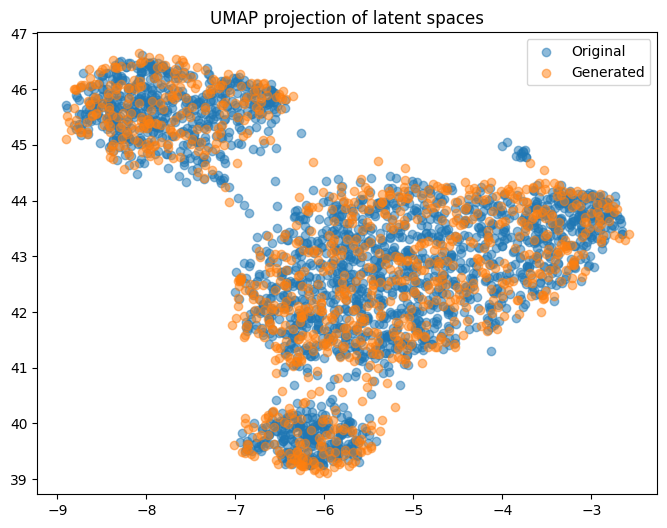

In [17]:
original_latent = latent  # already numpy
generated_latent = generated_cells.detach().cpu().numpy()
# Combine for projection
combined = np.vstack([original_latent, generated_latent])
labels = np.array([0]*original_latent.shape[0] + [1]*generated_latent.shape[0])

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(combined)

plt.figure(figsize=(8,6))
plt.scatter(embedding[labels==0,0], embedding[labels==0,1], alpha=0.5, label="Original")
plt.scatter(embedding[labels==1,0], embedding[labels==1,1], alpha=0.5, label="Generated")
plt.legend()
plt.title("UMAP projection of latent spaces")
plt.show()

- Decoding of generated cells

In [18]:
# Move latent and generated cells to device
latent_tensor = torch.tensor(latent, dtype=torch.float32, device=device)
generated_tensor = torch.tensor(generated_cells, dtype=torch.float32, device=device)
X_merged = []
labels = []
# Compute per-dimension standard deviation
std_orig = latent_tensor.std(dim=0)
std_gen = generated_tensor.std(dim=0)

# Rescale generated latent to match original std
generated_rescaled = generated_tensor #(generated_tensor - generated_tensor.mean(dim=0)) / std_gen * std_orig + latent_tensor.mean(dim=0)
#generated_rescaled = (generated_tensor - generated_tensor.mean(dim=0)) / std_gen * std_orig + latent_tensor.mean(dim=0)

with torch.no_grad():
    # Decode original latent cells
    outputs_latent = model.decode(latent_tensor, adata)
    mu_latent = outputs_latent["mu"]
    theta_latent = torch.exp(outputs_latent["theta"])

    # Decode flow-generated latent cells
    #outputs_gen = model.decode(generated_tensor, 1800)
    outputs_gen = model.decode(generated_rescaled, adata)
    mu_gen = outputs_gen["mu"]
    theta_gen = torch.exp(outputs_gen["theta"])
    
    #X_hat = NegativeBinomial(mu=mu_hat, theta=torch.exp(model.theta)).sample() # We <3 Mikkel

    # Sample from NB distribution
    nb_latent = NegativeBinomial(mu=mu_latent, theta=torch.exp(model.theta)).sample() 

    nb_generated = NegativeBinomial(mu=mu_gen, theta=torch.exp(model.theta)).sample() 
    X_merged.append(nb_latent.cpu().numpy())
    X_merged.append(nb_generated.cpu().numpy())
    labels.extend(["Real" for _ in range(len(nb_latent))])
    labels.extend(["Generated" for _ in range(len(nb_generated))])
print("Original latent sampled shape:", nb_latent.shape)
print("Flow-generated sampled shape:", nb_generated.shape)


Original latent sampled shape: torch.Size([2110, 8573])
Flow-generated sampled shape: torch.Size([1000, 8573])


/tmp/ipykernel_4086487/3641602333.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  generated_tensor = torch.tensor(generated_cells, dtype=torch.float32, device=device)


- Saving decoded generated cells as an Anndata object

In [19]:
adata_gen = ad.AnnData(X=nb_generated.cpu().numpy())

# Assign gene names from test dataset
adata_gen.var_names = adata.var_names.copy()

# All generated cells are B cells
#adata_gen.obs["cell_type"] = "B cells"
adata_gen.obs["dataset"] = "generated"

#sc.pp.filter_genes(adata, min_cells=20)

# Save the generated AnnData
adata_gen.write(gen_adata_path)

- UMAP comparing generated with training cells

In [20]:
X_merged = np.concatenate(X_merged)
adata_mer = sc.AnnData(X=X_merged, 
                   obs={"dataset_type": labels})
sc.pp.normalize_total(adata_mer, target_sum=1e4)
sc.pp.log1p(adata_mer)
sc.tl.pca(adata_mer)
sc.pp.neighbors(adata_mer)
sc.tl.umap(adata_mer)

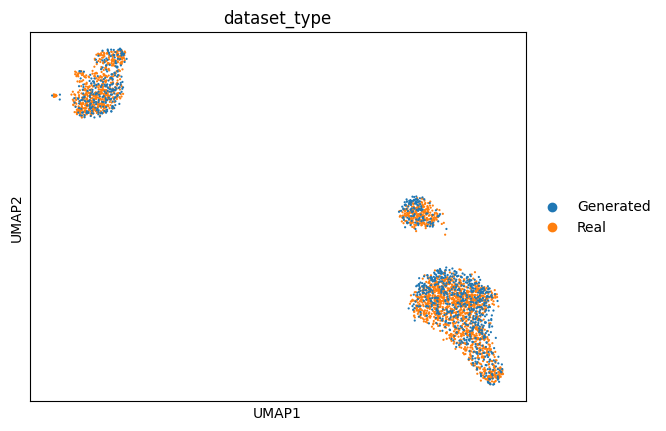

In [21]:
sc.pl.umap(adata_mer, color="dataset_type", s=10, save="flowmatching_umap.png")